# HW2. Множественная проверка гипотез, выбросы
#### Ильичёв А.С., 693

In [6]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import pandas as pd

%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 5) 


## Задача 2

Процедура Холма:

$\alpha_i = \frac{\alpha}{m-i+1}$. Если $p_{(i)} \ge \alpha_i$ - принимаем все гипотезы, начиная с данной, и останавливаемся, иначе отвергаем данную гипотезу и продолжаем, и так далее.

Пусть $h$ - первая отвергнутая верная гипотеза, $m_0$ - количество верных гипотез, $H_{(1)}, \dots, H_{(h-1)}$ - отвергнутые гипотезы (ложные по нашему предположению). Тогда $h-1\le m-m_0$ (количество ложных гипотез). Отсюда получаем $\frac{1}{m-h+1} \le \frac{1}{m_0}$. По определению процедуры мы имеем $p_{(h)} \le \frac{\alpha}{m-h+1} \le \frac{\alpha}{m_0}$, то есть мы отвергаем верную гипотезу с вероятностью не больше, чем $\frac{\alpha}{m_0}$. Тогда аналогично методу Бонферрони имеем:

$$
FWER = P(V > 0) = P(\exists j\in M_0: p_j \le \frac{\alpha}{m_0}) \le m_0 \cdot \frac{\alpha}{m_0} = \alpha, 
$$
ч.т.д.

## Задача 3

In [7]:
wine = pd.read_csv('wine.data.txt', header=None)

In [8]:
wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [9]:
wine_sample = wine[1]

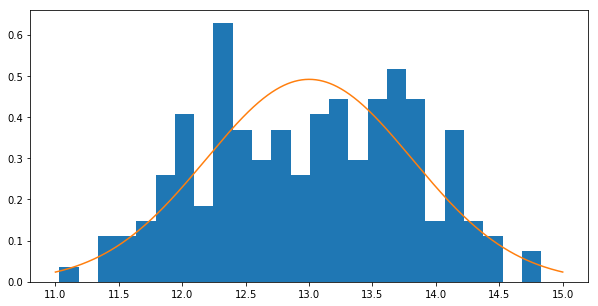

In [10]:
plt.hist(wine_sample, bins=25, density=True)
xs = np.linspace(11, 15, 1000)
plt.plot(xs, sts.norm(loc=wine_sample.mean(), scale=wine_sample.std()).pdf(xs))
plt.show()

Выберем 5 критериев проверки нормальности: 

In [11]:
import statsmodels.stats.diagnostic as diag
import statsmodels.stats.stattools as tools

def p_lilliefors(sample):
    return diag.lilliefors(sample, dist='norm')[1]

def p_jarque_bera(sample):
    return tools.jarque_bera(sample)[1]
    
def p_anderson_darling(sample):
    return diag.normal_ad(sample)[1]

def p_shapiro_wilk(sample):
    return sts.shapiro(sample)[1]

def p_normaltest(sample):
    return sts.normaltest(sample)[1]

p_funcs = [p_lilliefors, p_jarque_bera, p_anderson_darling, p_shapiro_wilk, p_normaltest]

Будем использовать метод Холма, так как он наиболее мощный среди контролирующих FWER на уровне $\alpha$ при отсутствии информации о характере зависимости между статистиками. Они не независимы, потому что, например, normaltest и метод Харке-Бера используют skewness и kurtosis, но с разными весами. 

In [12]:
def holm(sample, p_funcs, alpha=0.05):
    pvalues = [p_func(sample) for p_func in p_funcs]
    m = len(pvalues)
    stop = m
    acc = False
    answers = np.full(m, True)
    for i, (num, pval) in (enumerate(sorted(enumerate(pvalues), key=lambda x: x[1]))):
        threshold = alpha / (m - i)
        if pval >= threshold:
            stop = i
            acc = True
        print('{}: {}, p={}, threshold={}, acc={}'.format(i+1, p_funcs[num].__name__, pval, threshold, acc))
        if acc:
            break
        answers[num] = acc
    return answers

In [14]:
holm(wine_sample, p_funcs)

1: p_normaltest, p=0.00034163202531285264, threshold=0.01, acc=False
2: p_anderson_darling, p=0.009931995671743278, threshold=0.0125, acc=False
3: p_shapiro_wilk, p=0.02005171775817871, threshold=0.016666666666666666, acc=True


array([ True,  True, False,  True, False])

Вообще, метод Холма останавливается, когда принимает хотя бы одну гипотезу. Но тут мы проверяем одну и ту же гипотезу на одних и тех же данных, так что нам следует остановиться после первой же отвергнутой. Таким образом, мы отвергаем гипотезу о нормальности выборки на уровне значимости 0.05.

## Задача 4

In [15]:
sample4 = np.load('hw4t4.npy')
len(sample4)

1000

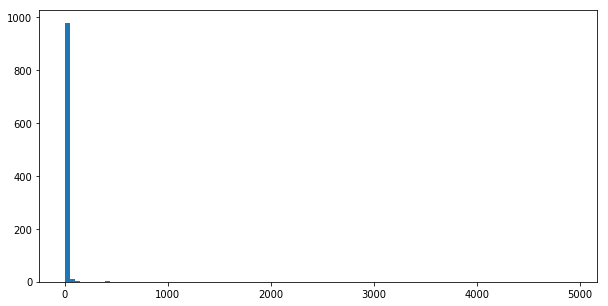

In [16]:
plt.hist(sample4, bins=100);

In [17]:
sorted(sample4, reverse=True)[:20]

[4920.797509006718,
 4350.9663533823195,
 3780.2215332310416,
 1858.446360236833,
 847.5049034569635,
 522.0896089841228,
 423.23194352701415,
 398.8777590079071,
 313.4389498145297,
 203.99461945248737,
 168.37595296265,
 118.68854484886197,
 98.89741873459543,
 96.6225779762715,
 94.58933478435856,
 89.69871921581012,
 87.86760083711596,
 78.47764829052663,
 65.34956487988298,
 63.61834976424348]

В выборке присутствует несколько очень больших значений, из-за которых гистограмма получается неинформативной. Скорее всего, это выбросы,тем более, речь идет о сроке службы лампочек в годах, и значения больше 50 тут вряд ли (СССР успел распасться за это время). Возможно, кто-то перепутал и добавил в выборку срок службы в днях. Уберем выбросы с помощью границ Тьюки, взяв только правую границу, потому что выбросы только с одной стороны. 

In [18]:
q1 = np.percentile(sample4, 25)
q3 = np.percentile(sample4, 75) 
k = 1.5
q1, q3

(1.1841529338117915, 6.5564940296289)

In [19]:
right = q3 + k * (q3 - q1)
right

14.615005673354563

In [20]:
sample4_cut = sample4[sample4 <= right]
len(sample4_cut)

937

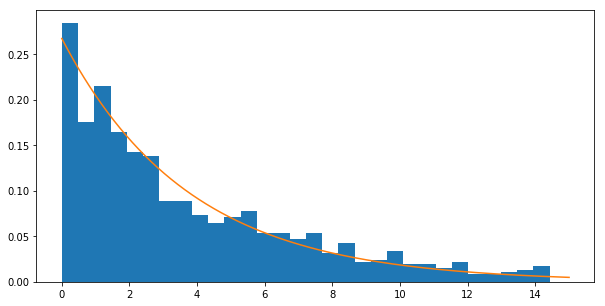

In [21]:
plt.hist(sample4_cut, bins=30, density=True)
xs = np.linspace(0, 15, 1000)
plt.plot(xs, sts.expon(scale=sample4_cut.mean()).pdf(xs))
plt.show()

Воспользуемся модификацией критерия Колмогорова-Смирнова для проверки экспоненциальности на уровне значимости 0.05. 

In [22]:
diag.lilliefors(sample4_cut, dist='exp')

(0.03841956114458478, 0.2)

P-value больше уровня значимости, поэтому мы принимаем гипотезу об экспоненциальности выборки.

Оценку среднего срока службы лампочки найдем как выборочное среднее после удаления выбросов.

In [23]:
sample4_cut.mean()

3.744212438329417

Почти 4 года - выглядит довольно реалистично.

## Задача 5

Получим все выборки.

__Комментарий__: Предполагается, что имелась в виду все-таки задача 2 из третьего ДЗ - там были выборки из нормального распределения, и в прошлом году она была под номером 3.

In [24]:
samples = dict()

In [25]:
df = pd.read_csv("slump_test.data.txt")
slump = np.array(df['Compressive Strength (28-day)(Mpa)'])
samples['slump'] = slump

In [26]:
samples['alcanity'] = np.array(wine[4])

In [27]:
df = pd.read_csv('vowel-context.data.txt', delimiter=' ', header=None)
vowel = np.array(df[7])
samples['vowel'] = vowel

In [28]:
samples['alcohol'] = np.array(wine_sample)
samples['ash'] = np.array(wine[3])
samples['phenols'] = np.array(wine[8])
samples['proanthocyanins'] = np.array(wine[9])

Применять процедуру Бенджамини-Хохберга здесь нельзя, потому что мы не можем утверждать независимость выборок, а свойство PDRS проверить нельзя, т.к. нам неизвестно распределение выборок.

In [29]:
def Iekutelli(pvalues, alpha):
    m = len(pvalues)
    stop = -1
    const = (1./(1+np.arange(m))).sum()
    acc = True
    answers = np.full(m, False)
    for i, (num, pval) in (enumerate(sorted(enumerate(pvalues), key=lambda x: x[1], reverse=True))):
        j = m - i
        threshold = alpha * j / (m*const)
        if pval < threshold:
            stop = j
            acc = False
        print('{}: p={}, threshold={}, acc={}'.format(i+1, pval, threshold, acc))
        if not acc:
            break
        answers[num] = acc
    return answers


In [30]:
pvalues = []
for sample in samples.values():
    pvalues += [func(sample) for func in p_funcs]

Восходящая процедура работает до первой отвергнутой гипотезы.

In [31]:
answers = Iekutelli(pvalues, 0.05)

1: p=0.7066830538902151, threshold=0.012057544140306832, acc=True
2: p=0.5915089995351763, threshold=0.011713042879155209, acc=True
3: p=0.48257023096084595, threshold=0.011368541618003585, acc=True
4: p=0.4058566033223445, threshold=0.01102404035685196, acc=True
5: p=0.26386943459510803, threshold=0.010679539095700337, acc=True
6: p=0.25093384267983715, threshold=0.010335037834548713, acc=True
7: p=0.21004273588925534, threshold=0.00999053657339709, acc=True
8: p=0.20530828569458984, threshold=0.009646035312245466, acc=True
9: p=0.2001436767305555, threshold=0.009301534051093841, acc=True
10: p=0.2, threshold=0.008957032789942218, acc=True
11: p=0.2, threshold=0.008612531528790594, acc=True
12: p=0.2, threshold=0.008268030267638971, acc=True
13: p=0.139149465722061, threshold=0.007923529006487347, acc=True
14: p=0.08258012323052723, threshold=0.007579027745335723, acc=True
15: p=0.07713065093198859, threshold=0.007234526484184099, acc=True
16: p=0.07521317731672612, threshold=0.006890

Если мы проверяем гипотезу о нормальности __всех__ выборок сразу, то ее следует отвергнуть. Проверим теперь гипотезы о нормальности каждой выборки, основываясь на этом тесте.

In [32]:
ind = 0
for name in samples.keys():
    sample_answers = answers[ind:ind+5]
    print(name, ":", sample_answers)
    ind += 5

slump : [ True  True  True  True  True]
alcanity : [ True  True  True  True  True]
vowel : [ True  True  True  True  True]
alcohol : [ True  True  True  True False]
ash : [ True  True  True  True  True]
phenols : [False  True False False  True]
proanthocyanins : [ True  True  True  True  True]


Для всех выборок, кроме alcohol и phenols, гипотеза о нормальности принимается (здесь мы, так же как в 3 задаче, отвергаем гипотезу, если ее отверг хотя бы один критерий, т.к. данные и гипотезы одни и те же). Для alcohol мы уже получили такой же результат (отвергли гипотезу) в третьей задаче. Посмотрим на гистограмму phenols.

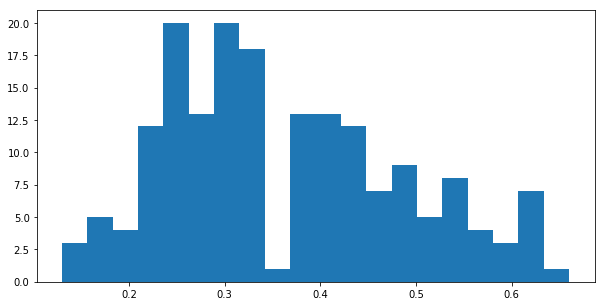

In [33]:
plt.hist(samples['phenols'], bins=20);

И правда не похоже на нормальное.